[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/trabajo-final_AA1/blob/main/notebooks_pasos_previos/00_preprocesamiento_dataset_clasificacion.ipynb)



# Preparación y preprocesamiento de datos del dataset Ninapro DB1

## Descripción corta del dataset

*Ninapro* ([link](https://ninapro.hevs.ch/)) es un base de datos publica destinada a fomentar la investigación de aprendizaje automático en manos humanas, robóticas y protésicas. *Ninapro* posee 10 datasets que incluyen 180 adquisiciones de datos de sujetos sanos y con amputacion transradial (debajo del codo). 

En este caso especifico, se seleccionó el dataset [DB1](https://ninapro.hevs.ch/instructions/DB1.html) el cual se describe brevemente en la siguiente tabla:

| Columna                     | Descripción                                                   | Ejemplo                |
|:----------------------------|:--------------------------------------------------------------|:-----------------------|
| `Subject`                   | Sujeto                                                        | 01                     |
| `Hand`                      | Mano                                                          | Intact                 |
| `Handedness`                | Lateralidad                                                   | Right / Left           |
| `Gender`                    | Genero                                                        | Male / Female          |
| `Age`                       | Edad                                                          | 31                     |
| `Height`                    | Altura                                                        | 170                    |
| `Weight`                    | Peso                                                          | 75                     |
| `zip files`                 | Archivos con las adquisición de los datos                     | s1.zip                 |

En DB1, existen 27 archivos comprimidos (`S1.zip`, `S2.zip`, ..., `S27.zip`) con la adquisición de datos de los sujetos. Cada archivo contiene un directorio con tres archivos MAT (Matlab) con el siguiente formado `Sx_Ay_Ez.mat` donde:
* **`x`**: Numero del sujeto (entre 1 y 27).
* **`y`**: Adquisición (A1: Primera adquisición).
* **`z`**: Numero del ejercicio: 1, 2 o 3.

Como nuestro trabajo solo se va a centrar en las posturas del ejercicio uno, solo nos va a interesar los archivos MAT de la forma `Sx_A1_E1.mat` de cada uno de los 27 sujetos.

## Objetivo a desarrollar

> Obtener del dataset crudo los datos, combinarlos y realizar una transformación simple para hacerlos aptos para el entrenamiento de los modelos a emplear.

## Resumen del proceso realizado

El procedimiento se resume en los siguientes pasos:
1. Combinación de los datasets del ejercicio 1 (`Sx_A1_E3.mat`) de los 27 sujetos de prueba en un unico dataset.
2. Conocimiento de la forma básica del dataset para identificar las columnas asociadas a los sensores de electromiografia, el numero de repeticiones y la postura realizada; los cuales representan los datos de interes.
3. Extracción las columnas de interes, realizar una visualización rapida de las señales y comprender el contexto de uso de estas.
4. Realición del preproceamiento de las señales adquiridas el cual se resume en:
   * **Filtrado**: Eliminar el ruido que pueda tener la señal. El filtrado se hara para toda la base de datos.
   * **Enventanado**: Tomar porciones de la señal para hacer un analisis localizado. Es importante tener en cuenta que solo se seleccionó la información asociada a los 10 primeros sujetos de los 27 que tiene la base de datos.
5. Extracción de caracteristicas sobre cada segmento de la señal (ventana) con el fin de reducir la cantidad de información para alimentar los modelos. 
6. A partir la base de datos que contiene los vectores caracteristicos de las ventanas de tiempo de la información de los 10 sujetos seleccionadas se generó un archivo CSV para las etapas siguientes del proceso de analitica de datos.

A continuación se trabaja sobre las plantillas que el profesor nos facilito durante el curso.

## 1. Librerias y configuraciones previas


In [1]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
    print("La librería 'scipy' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'scipy' no está instalada.")
    print("Instalando 'scipy'...")
    !pip install scipy

try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")
    print("Instalando 'libEMG'...")
    !pip install libemg

try:
    import imblearn
    print("La librería 'imblearn' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'imblearn' no está instalada.")
    print("Instalando 'imblearn'...")
    !pip install imblearn

try:
    import mlflow
    print("La librería 'mlflow' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'mlflow' no está instalada.")
    print("Instalando 'mlflow'...")
    !pip install mlflow

La librería 'scipy' está instalada y se ha importado correctamente.
La librería 'libEMG' está instalada y se ha importado correctamente.
La librería 'imblearn' está instalada y se ha importado correctamente.
La librería 'mlflow' está instalada y se ha importado correctamente.


In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

# Biblioteca scipy y componentes
# ==============================================================================
import scipy.io
from scipy import signal


In [3]:
import requests
from tqdm import tqdm
import os
import zipfile
import sys

In [4]:
from libemg.data_handler import OfflineDataHandler, RegexFilter
from libemg.utils import get_windows
from libemg.feature_extractor import FeatureExtractor

## 2. Funciones

In [14]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
# from utils.funciones1 import multiple_plot
# from utils.funciones2 import test_hola, graficar_medida, graficar_medida2, filter_signal, \
#                             segmentar_data_base, aplanar_data_base, aplanar_ventana, \
#                             rms_value, mav_value, features_data_base

def find_value_ranges(arr, value):
    """
    Encuentra los rangos (inicio, fin) donde el valor dado aparece de forma continua en un array.

    Parámetros:
        arr (array-like): arreglo de entrada (lista o np.array).
        value (int o float): valor objetivo para encontrar bloques contiguos.

    Retorna:
        List[Tuple[int, int]]: lista de tuplas (inicio, fin) donde aparecen bloques del valor.
    """
    arr = np.asarray(arr)
    ranges = []
    in_range = False

    for i, val in enumerate(arr):
        if val == value and not in_range:
            start = i
            in_range = True
        elif val != value and in_range:
            end = i - 1
            ranges.append((start, end))
            in_range = False

    # Si termina en un bloque del valor
    if in_range:
        ranges.append((start, len(arr) - 1))

    return ranges

## 3. Carga y preprocesamiento del dataset original

Configuración inicial

In [5]:
# Agregar el directorio raíz del proyecto al PYTHONPATH
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Sube un nivel
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)
print(f"Directorio raíz del proyecto agregado al PYTHONPATH: {ROOT_DIR}")

Directorio raíz del proyecto agregado al PYTHONPATH: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia


In [6]:
# se importan las rutas
# from globals import SRC_DIR, DATA_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR
# Agregar el directorio SRC_DIR al PYTHONPATH
#if SRC_DIR not in sys.path:
#    sys.path.append(SRC_DIR)
from globals import RAW_DATA_DIR, PROCESSED_DATA_DIR
print(f"Ruta datos crudos: {RAW_DATA_DIR}")
print(f"Ruta datos procesados: {PROCESSED_DATA_DIR}")

Ruta datos crudos: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw
Ruta datos procesados: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\processed


### Visualización de un solo archivo MAT

Con el fin de conocer un poco lo que contiene un solo MAT vamos a realizar los siguientes procedimientos.

En nuestro analisis, solo nos va a interesar los datos de las columnas:
* **`emg`**: Señales EMG superficiales tomadas de los 10 electronos.
* **`rerepetition`**: Repetición de la postura de la mano (ejercicio) realizado. Cada postura se repetira 10 veces.
* **`restimulus`**: Postura manual (ejercicio) realizada.

### Caso de las señales EMG

Dado que los registros de la base de datos son señales (secuencias temporales), es necesario llevar a cabo una etapa adicional de **procesamiento digital de señales** con el fin de garantizar que los datos de entrada al modelo sean adecuados. En esta fase se realizan pasos clave; como la segmentación de la señal y la extracción de características mediante transformaciones. En nuestro caso se realizaron basicamente dos pasos en esta etapa:
1. Filtrado.
2. Segmentación.
3. Extracción de caracteristicas.

### Carga de datos

### Combinación de los archivos

In [9]:
# Listar y cargar los archivos .npy del directorio PROCESSED_DATA_DIR
npy_files = [f for f in os.listdir(PROCESSED_DATA_DIR) if f.endswith('.npy')]

data = []
for file in npy_files:
    file_path = os.path.join(PROCESSED_DATA_DIR, file)
    data.append(np.load(file_path))
    print(f"Archivo cargado: {file}")

Archivo cargado: data_ex3_subject_1.npy
Archivo cargado: data_ex3_subject_10.npy
Archivo cargado: data_ex3_subject_11.npy
Archivo cargado: data_ex3_subject_12.npy
Archivo cargado: data_ex3_subject_13.npy
Archivo cargado: data_ex3_subject_14.npy
Archivo cargado: data_ex3_subject_15.npy
Archivo cargado: data_ex3_subject_16.npy
Archivo cargado: data_ex3_subject_17.npy
Archivo cargado: data_ex3_subject_18.npy
Archivo cargado: data_ex3_subject_19.npy
Archivo cargado: data_ex3_subject_2.npy
Archivo cargado: data_ex3_subject_20.npy
Archivo cargado: data_ex3_subject_21.npy
Archivo cargado: data_ex3_subject_22.npy
Archivo cargado: data_ex3_subject_23.npy
Archivo cargado: data_ex3_subject_24.npy
Archivo cargado: data_ex3_subject_25.npy
Archivo cargado: data_ex3_subject_26.npy
Archivo cargado: data_ex3_subject_27.npy
Archivo cargado: data_ex3_subject_3.npy
Archivo cargado: data_ex3_subject_4.npy
Archivo cargado: data_ex3_subject_5.npy
Archivo cargado: data_ex3_subject_6.npy
Archivo cargado: data_

In [13]:
len(data)  # Mostrar la cantidad de archivos cargados

27

In [12]:
data[0].shape

(214236, 12)

In [8]:
data.keys()  # Mostrar las claves del diccionario 'data' para verificar los archivos cargados

dict_keys(['data_ex3_subject_1.npy', 'data_ex3_subject_10.npy', 'data_ex3_subject_11.npy', 'data_ex3_subject_12.npy', 'data_ex3_subject_13.npy', 'data_ex3_subject_14.npy', 'data_ex3_subject_15.npy', 'data_ex3_subject_16.npy', 'data_ex3_subject_17.npy', 'data_ex3_subject_18.npy', 'data_ex3_subject_19.npy', 'data_ex3_subject_2.npy', 'data_ex3_subject_20.npy', 'data_ex3_subject_21.npy', 'data_ex3_subject_22.npy', 'data_ex3_subject_23.npy', 'data_ex3_subject_24.npy', 'data_ex3_subject_25.npy', 'data_ex3_subject_26.npy', 'data_ex3_subject_27.npy', 'data_ex3_subject_3.npy', 'data_ex3_subject_4.npy', 'data_ex3_subject_5.npy', 'data_ex3_subject_6.npy', 'data_ex3_subject_7.npy', 'data_ex3_subject_8.npy', 'data_ex3_subject_9.npy'])

### Usuario de muestra

Nuevamente usemos el usuario de muestra 1 (indice = 0)

```
[ emg | restimulus | rerepetition ] = [ 0:9 | 10 | 11 ]
```

* **`restimulus`**: 1 - 23 (El reposo se toma como 0)
* **`rerepetition`**: 1 - 10

In [25]:
INDEX_SUB = 0
emg_s1 = data[INDEX_SUB][:,0:10]
restimulus_s1 = data[INDEX_SUB][:,10]
rerepetition_s1 = data[INDEX_SUB][:,11]
restimulus_s1

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
num_exercise = 23
s1_23 = find_value_ranges(restimulus_s1,23)  # Buscar los rangos de bloques de valor 1 en 'restimulus_s1'
s1_23


[(205973, 206474),
 (206747, 207279),
 (207625, 208150),
 (208450, 208947),
 (209254, 209765),
 (210081, 210590),
 (210893, 211393),
 (211730, 212241),
 (212589, 213101),
 (213419, 213973)]

In [23]:
def get_exercise_ranges(data, num_exercise):
    """
    Obtiene los rangos de inicio y fin de un ejercicio específico en los datos.

    Parámetros:
        data (array-like): arreglo de datos que contiene información sobre ejercicios.
        num_exercise (int): número del ejercicio a buscar.

    Retorna:
        List[Tuple[int, int]]: lista de tuplas (inicio, fin) donde aparecen bloques del ejercicio.
    """
    indexes = find_value_ranges(data, num_exercise)
    initial_idex = indexes[0][0]  # Primer índice de inicio
    final_idex = indexes[-1][1]  # Último índice de fin
    return initial_idex, final_idex  # Retorna el rango del ejercicio específico

In [38]:
def get_multiple_exercise_ranges(data, exercise_numbers):
    """
    Obtiene los rangos de inicio y fin para múltiples ejercicios específicos en los datos.

    Parámetros:
        data (array-like): arreglo de datos que contiene información sobre ejercicios.
        exercise_numbers (list): lista de números de ejercicios a buscar.

    Retorna:
        dict: un diccionario donde las claves son los números de ejercicios y los valores son listas de rangos (inicio, fin).
    """
    ranges_dict = {}
    for num_exercise in exercise_numbers:
        ranges_dict[num_exercise] = get_exercise_ranges(data, num_exercise)
    return ranges_dict

In [34]:
ini_23, end_23 = get_exercise_ranges(restimulus_s1,23)

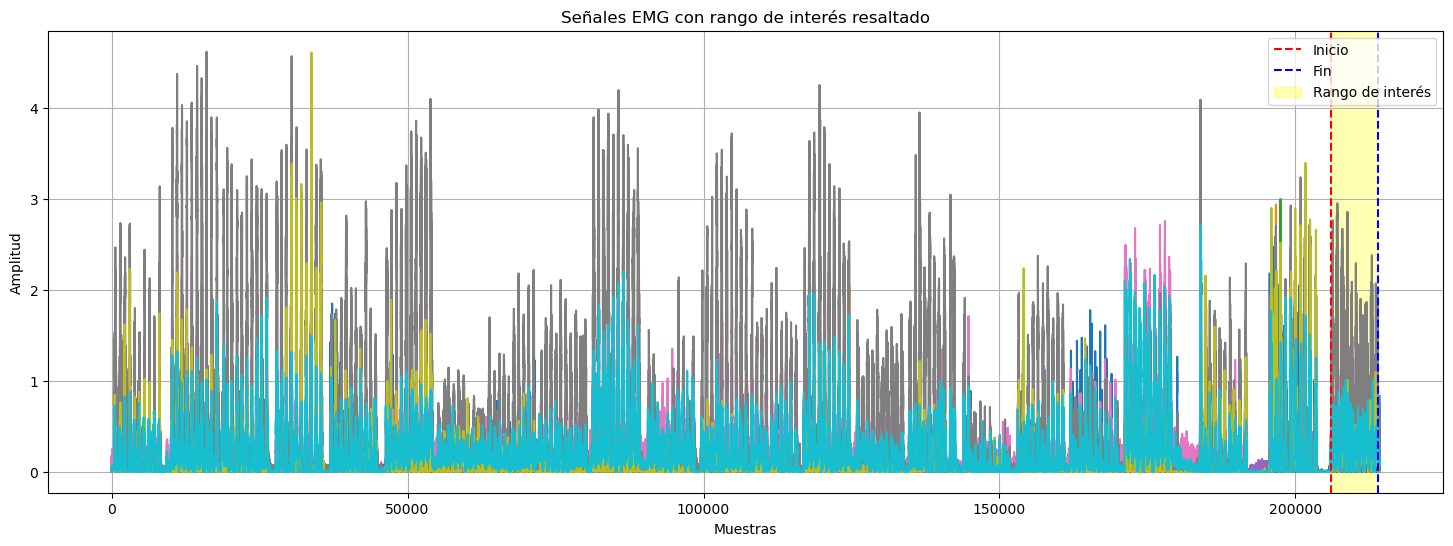

In [28]:
plt.figure(figsize=(18, 6))

# Graficar las señales EMG
for i in range(emg_s1.shape[1]):  # Iterar sobre cada canal de EMG
    # plt.plot(emg_s1[:, i], label=f'Canal {i+1}')
    plt.plot(emg_s1[:, i])

# Agregar líneas verticales en ini_23 y end_23
plt.axvline(x=ini_23, color='red', linestyle='--', label='Inicio')
plt.axvline(x=end_23, color='blue', linestyle='--', label='Fin')

# Agregar un fondo claro entre las líneas
plt.axvspan(ini_23, end_23, color='yellow', alpha=0.3, label='Rango de interés')

# Configurar etiquetas y leyenda
plt.title('Señales EMG con rango de interés resaltado')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [39]:
index_ejercicios_s1 = get_multiple_exercise_ranges(restimulus_s1, [1,23])
index_ejercicios_s1

{1: (436, 8272), 23: (205973, 213973)}

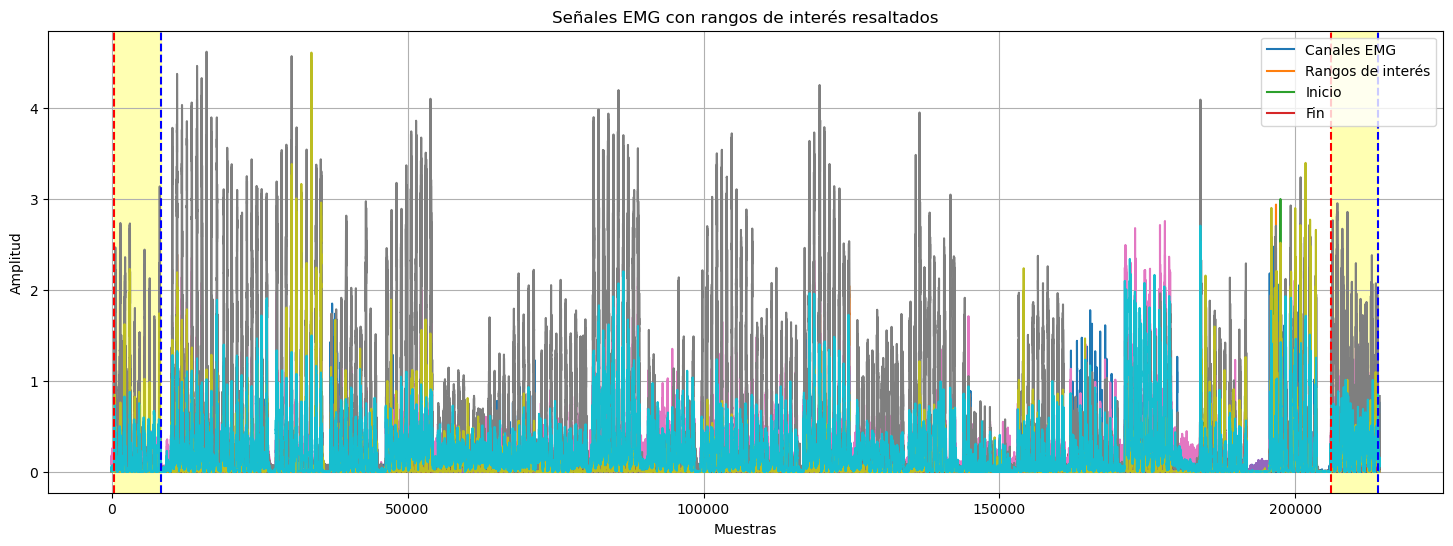

In [42]:
plt.figure(figsize=(18, 6))

# Graficar las señales EMG
for i in range(emg_s1.shape[1]):  # Iterar sobre cada canal de EMG
    plt.plot(emg_s1[:, i])

# Resaltar las regiones entre los rangos encontrados en index_ejercicios_s1
for exercise, (start, end) in index_ejercicios_s1.items():
    plt.axvspan(start, end, color='yellow', alpha=0.3, label=f'Ejercicio {exercise}')
    plt.axvline(x=start, color='red', linestyle='--', label=f'Inicio Ejercicio {exercise}')
    plt.axvline(x=end, color='blue', linestyle='--', label=f'Fin Ejercicio {exercise}')

# Configurar etiquetas y leyenda
plt.title('Señales EMG con rangos de interés resaltados')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend(['Canales EMG', 'Rangos de interés', 'Inicio', 'Fin'])
plt.grid(True)

# Mostrar la gráfica
plt.show()

**To Do...**

Queda pendiente agregar para el rango la parte asociada al 0 (sumar y restar algunos valore a los indices.)

## Conclusiones

Al finalizar este notebook se logro.
* To Do...